In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from PIL import Image



2024-05-30 09:13:08.137345: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 09:13:08.137448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 09:13:08.238366: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Function to load images from folder
def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename)).convert('L')  # Convert to grayscale
        if img is not None:
            img = img.resize((100, 100))  # Resize images to a common shape
            images.append(np.array(img))
            if folder.endswith('/Bacterialblight'):
                labels.append('Bacterialblight')
            elif folder.endswith('/Brownspot'):
                labels.append('Brownspot')
            elif folder.endswith('/Leafsmut'):
                labels.append('Leafsmut')
            else:
                labels.append('unknown')  # If folder doesn't match any expected label
    return images, labels

In [3]:
# Define folder paths
folder_paths = ['/kaggle/input/rice-plant-diseases-dataset/rice leaf diseases dataset/Bacterialblight', '/kaggle/input/rice-plant-diseases-dataset/rice leaf diseases dataset/Brownspot', '/kaggle/input/rice-plant-diseases-dataset/rice leaf diseases dataset/Leafsmut']


In [4]:
# Load images and labels
images = []
all_labels = []
for folder_path in folder_paths:
    folder_images, folder_labels = load_images_from_folder(folder_path)
    images.extend(folder_images)
    all_labels.extend(folder_labels)

In [5]:
# Convert to numpy arrays
X = np.array(images)
y = np.array(all_labels)

In [6]:
# Normalize pixel values
X = X.astype('float32') / 255.0

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [9]:
# Define RNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')  # Assuming 3 classes
])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# Check if GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

# Use MirroredStrategy to distribute the model across all available GPUs
strategy = tf.distribute.MirroredStrategy()

Default GPU Device: /device:GPU:0


In [11]:
# Create and compile the model within the strategy's scope
with strategy.scope():
    model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')  # Assuming 3 classes
])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    

    # Train the model
    history = model.fit(X_train, y_train_encoded, epochs=200, batch_size=32, validation_data=(X_test, y_test_encoded))


Epoch 1/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.3988 - loss: 1.1199 - val_accuracy: 0.4098 - val_loss: 1.0709
Epoch 2/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 139ms/step - accuracy: 0.4665 - loss: 1.0490 - val_accuracy: 0.4653 - val_loss: 1.0496
Epoch 3/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 0.4618 - loss: 1.0331 - val_accuracy: 0.4845 - val_loss: 1.0261
Epoch 4/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 0.4798 - loss: 1.0308 - val_accuracy: 0.4920 - val_loss: 1.0085
Epoch 5/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 0.4873 - loss: 1.0225 - val_accuracy: 0.5037 - val_loss: 1.0258
Epoch 6/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 0.4907 - loss: 1.0204 - val_accuracy: 0.5069 - val_loss: 1.0141
Epoch 7/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 0.4977 - loss: 1.0135 - val_accuracy: 0.4461 - val_loss: 1.0618
Epoch 8/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 0.5012 -

In [12]:
# Summary of the model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 100, 128)       │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,059 (539.30 KB)

 Trainable params: 46,019 (179.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 92,040 (359.54 KB)

In [13]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print('Test accuracy:', test_acc)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9563 - loss: 0.2461
Test accuracy: 0.9583777785301208


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


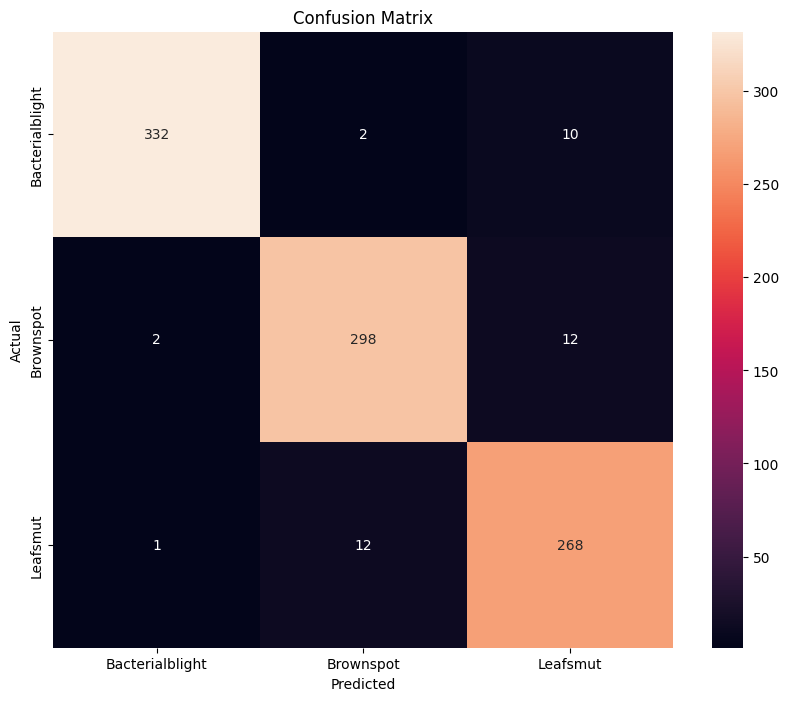

In [14]:
# Confusion matrix
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test_encoded, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

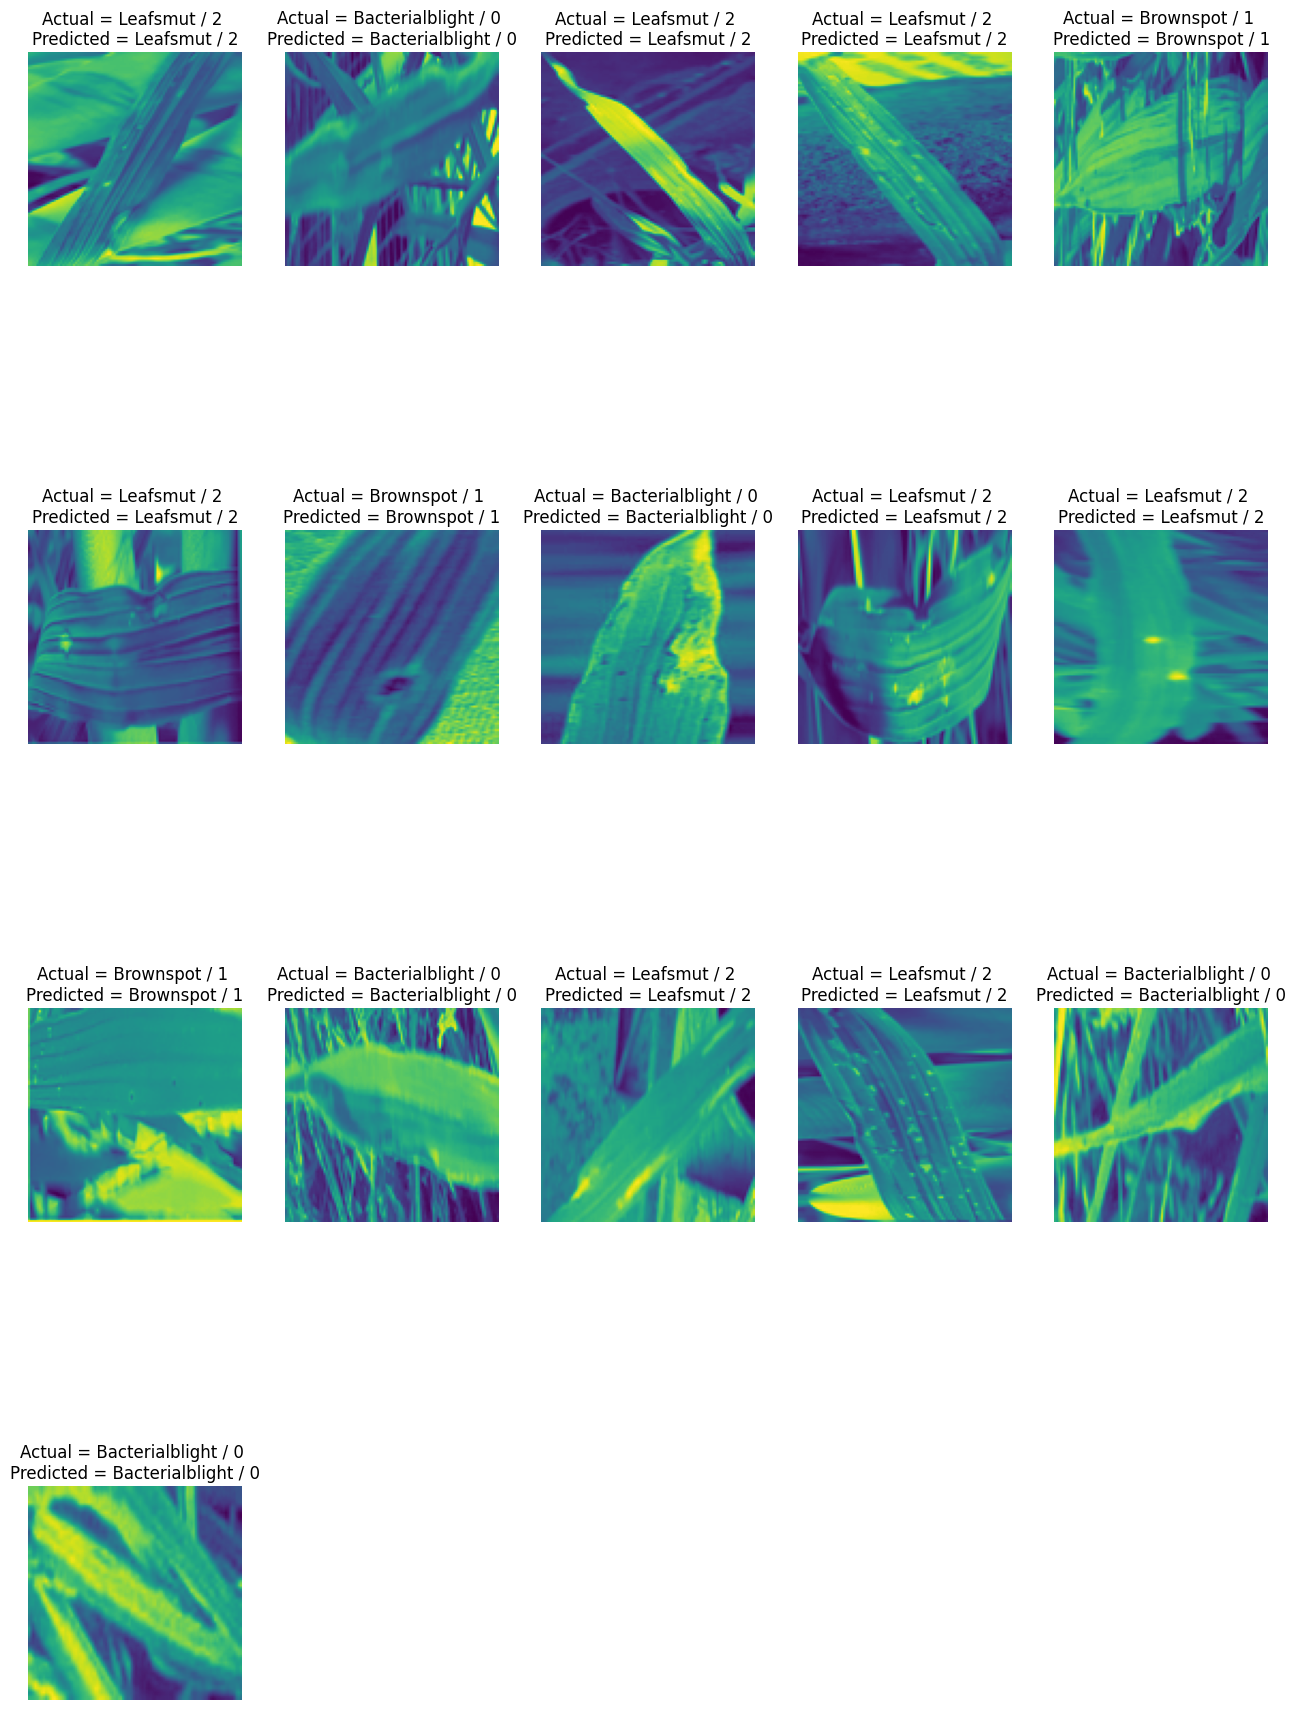

In [15]:
# Visualization of random test images with actual and predicted labels
plt.figure(figsize=(16, 30))
j = 1
for i in np.random.randint(0, len(X_test), 16):
    plt.subplot(5, 5, j)
    j += 1
    plt.imshow(X_test[i])
    plt.axis('off')
    actual_label = label_encoder.inverse_transform([y_test_encoded[i]])[0]
    predicted_label = label_encoder.inverse_transform([np.argmax(y_pred[i])])[0]
    plt.title('Actual = {} / {} \nPredicted = {} / {}'.format(actual_label, y_test_encoded[i], predicted_label, np.argmax(y_pred[i])))

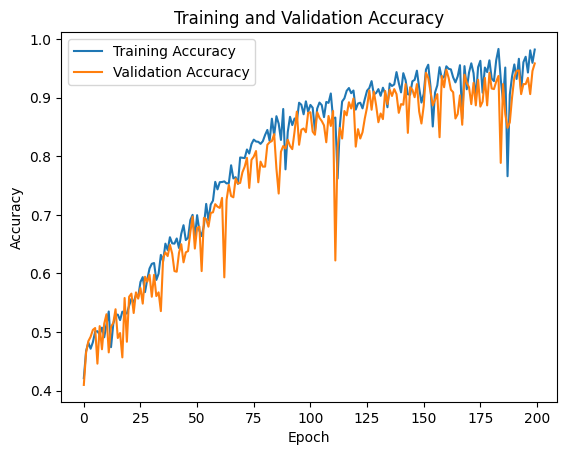

In [16]:

# Plot training history: Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

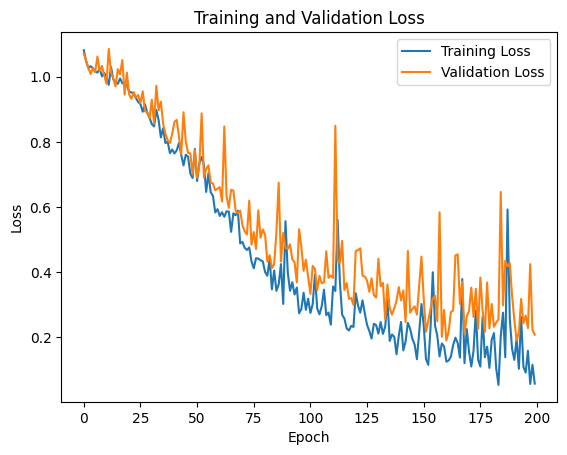

In [17]:


# Plot training history: Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()